# Read Log files

In [1]:
import pandas as pd
import re
from typing import List

def parse_single_file(filepath):
    """
    Parse a single log file and return a DataFrame with:
    user, selected_user, datetime, duration, document_distance, rating, query, answer, source

    :param filepath: Path to a single log file.
    :return: A pandas DataFrame with parsed log information from that file.
    """
    
    # Regex patterns
    datetime_pattern = re.compile(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}')
    selected_user_pattern = re.compile(r'^Selected User:\s*(.*)')
    user_pattern = re.compile(r'^User:\s*([0-9a-fA-F-]+)')
    duration_pattern = re.compile(r'^Duration:\s*([\d.]+)\s*seconds')
    doc_distance_pattern = re.compile(r'^Document distance:\s*([\d.]+)')
    query_pattern = re.compile(r'^Query:\s*(.*)')
    response_pattern = re.compile(r'^Response:\s*(.*)')
    rating_pattern = re.compile(r'^User\s+([0-9a-fA-F-]+)\s+rated the response:\s+(\d+)/10')
    source_pattern = re.compile(r'^Source:\s*(.*)')
    
    entries = []
    current_entry = {}
    collecting_response = False
    
    def store_and_reset(entry_dict):
        """Store the current entry_dict in entries if it’s valid, then reset it."""
        if "datetime" in entry_dict and "user" in entry_dict:
            entry_dict.setdefault("selected_user", None)
            entry_dict.setdefault("duration", None)
            entry_dict.setdefault("document_distance", None)
            entry_dict.setdefault("rating", None)
            entry_dict.setdefault("query", None)
            entry_dict.setdefault("answer", None)
            entry_dict.setdefault("source", None)
            entries.append(entry_dict)
        return {}

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip('\n')
            
            # Check for rating line
            rate_match = rating_pattern.match(line)
            if rate_match:
                rated_user = rate_match.group(1)
                rated_value = rate_match.group(2)
                # First, try to assign rating to the current entry if it matches the user and has no rating yet.
                if current_entry.get("user") == rated_user and (current_entry.get("rating") is None or current_entry.get("rating") == ""):
                    current_entry["rating"] = rated_value
                else:
                    # Otherwise, search through previously stored entries (in reverse order)
                    for e in reversed(entries):
                        if e.get("user") == rated_user and (e.get("rating") is None or e.get("rating") == ""):
                            e["rating"] = rated_value
                            break
                continue
            
            # Check if the line starts a new block (datetime)
            if datetime_pattern.match(line):
                # If we're currently holding a block, store it first
                if current_entry:
                    current_entry = store_and_reset(current_entry)
                
                # Start a new block
                current_entry["datetime"] = line.strip()
                collecting_response = False
                continue
            
            # Selected user
            select_user_match = selected_user_pattern.match(line)
            if select_user_match:
                current_entry["selected_user"] = select_user_match.group(1).strip()
                continue
            
            # User
            user_match = user_pattern.match(line)
            if user_match:
                current_entry["user"] = user_match.group(1).strip()
                continue
            
            # Duration
            duration_match = duration_pattern.match(line)
            if duration_match:
                current_entry["duration"] = duration_match.group(1).strip()
                continue
            
            # Document distance
            doc_dist_match = doc_distance_pattern.match(line)
            if doc_dist_match:
                current_entry["document_distance"] = doc_dist_match.group(1).strip()
                continue
            
            # Query
            query_match = query_pattern.match(line)
            if query_match:
                current_entry["query"] = query_match.group(1).strip()
                collecting_response = True
                current_entry.setdefault("answer", "")
                continue
            
            # Collecting response
            if collecting_response:
                resp_match = response_pattern.match(line)
                if resp_match:
                    current_entry["answer"] = resp_match.group(1).strip()
                    continue
                
                source_match = source_pattern.match(line)
                if source_match:
                    current_entry["source"] = source_match.group(1).strip()
                    collecting_response = False
                    continue
                
                # Separator or next block indicator
                if line.startswith("---"):
                    collecting_response = False
                    continue
                
                # Otherwise, if the line is not recognized as a new metadata field, append to the answer.
                if not (datetime_pattern.match(line) or
                        selected_user_pattern.match(line) or
                        user_pattern.match(line) or
                        duration_pattern.match(line) or
                        doc_distance_pattern.match(line) or
                        query_pattern.match(line) or
                        rating_pattern.match(line) or
                        source_pattern.match(line) or
                        line.strip("-") == ""):
                    current_entry["answer"] += "\n" + line.strip()
    
    # Store the last block if any
    if current_entry:
        store_and_reset(current_entry)
    
    df = pd.DataFrame(entries, columns=[
        "user",
        "selected_user",
        "datetime",
        "duration",
        "document_distance",
        "rating",
        "query",
        "answer",
        "source"
    ])
    
    return df

def parse_multiple_files_to_dataframe(filepaths: List[str]) -> pd.DataFrame:
    """
    Parse multiple log files (specified in filepaths) and return
    a single combined DataFrame.
    
    :param filepaths: A list of file paths to log files.
    :return: A pandas DataFrame with all parsed log information combined.
    """
    all_dataframes = []
    for filepath in filepaths:
        df_single = parse_single_file(filepath)
        all_dataframes.append(df_single)
    
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
    else:
        # If no files provided or no data
        combined_df = pd.DataFrame(columns=[
            "user",
            "selected_user",
            "datetime",
            "duration",
            "document_distance",
            "rating",
            "query",
            "answer",
            "source"
        ])
    
    return combined_df


In [2]:
df_log = parse_multiple_files_to_dataframe(["1_chat_log.txt", "2_chat_log.txt", "3_chat_log.txt", "4_chat_log.txt"])

In [3]:
def export_to_csv(df: pd.DataFrame, filename: str) -> None:
    """
    Export the DataFrame to a CSV file without an index column.
    The CSV will include all columns in the DataFrame (e.g., user, query, correctness).
    
    :param df: The DataFrame to export.
    :param filename: The output CSV file path (e.g., 'output.csv').
    """
    df.to_csv(filename, index=False)

def read_data_from_csv(filename: str) -> pd.DataFrame:
    """
    Read a CSV file into a DataFrame.
    This will include any custom columns such as 'correctness'.
    
    :param filename: The CSV file path to read (e.g., 'output.csv').
    :return: A DataFrame containing the CSV data.
    """
    df = pd.read_csv(filename)
    return df


In [4]:
export_to_csv(df_log, "my_log_data.csv")

# Load evaluated csv

In [5]:
df = read_data_from_csv("edited_my_log_data.csv")

In [6]:
# df

In [7]:
# df.iloc[0]

In [8]:
def filter_by_notes(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> pd.DataFrame:
    """
    If notes_filter is provided, return only rows where the 'notes'
    column contains the given substring (case insensitive).
    If invert_notes is True, return rows that do NOT contain the given substring.
    Otherwise, return the entire DataFrame.
    """
    if notes_filter is not None:
        mask = df["notes"].str.contains(notes_filter, case=False, na=False)
        if invert_notes:
            mask = ~mask
        return df[mask]
    return df

# User eval
- How many unique Users
- User group distribution
- How many questions per user
- average rating per user and how many they rated
- 

In [9]:
def filter_users_by_question_count(df: pd.DataFrame, min_questions: int = 2) -> pd.DataFrame:
    """
    Filters the DataFrame to only include entries from users who have asked more than min_questions.

    :param df: The input DataFrame, which must contain a 'user' column.
    :param min_questions: The minimum number of questions a user must have asked (default is 2).
    :return: A filtered DataFrame containing only rows for users with more than min_questions questions.
    """
    # Count questions per user
    question_counts = df["user"].value_counts()
    # Get list of users with more than min_questions
    valid_users = question_counts[question_counts > min_questions].index
    # Filter the DataFrame to only include these users
    filtered_df = df[df["user"].isin(valid_users)]
    return filtered_df
df_qa = filter_users_by_question_count(df, min_questions=2)
print(df.shape)
# print(filtered_df.shape)

(223, 13)


In [10]:
# USER Metrics
def count_unique_users(df: pd.DataFrame) -> int:
    """
    Returns the number of unique users in the DataFrame.
    """
    return df["user"].nunique()

def questions_per_usergroup(df: pd.DataFrame) -> pd.Series:
    """
    Returns the distribution of user groups based on the 'selected_user' column.
    """
    return df["selected_user"].value_counts()
def user_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with the average rating, count of rating, and count of questions per user.
    """
    user_metrics_df = df.groupby("user").agg(
        avg_rating=("rating", "mean"),
        count_rating=("rating", "count"),
        count_questions=("query", "count")
    ).reset_index()
    return user_metrics_df

def unique_users_per_usergroup(df: pd.DataFrame) -> pd.Series:
    """
    Returns the number of unique users per user group.
    """
    return df.groupby("selected_user")["user"].nunique()

## before quality filtering

In [11]:
print("Unique users:", count_unique_users(df))
print("Questions per User group:\n", questions_per_usergroup(df))
print("Unique Users per Usergroup: ", unique_users_per_usergroup(df))
display("Average rating per user:\n", user_metrics(df))

Unique users: 39
Questions per User group:
 selected_user
HdM_Student    115
random_User     74
AI_Expert       34
Name: count, dtype: int64
Unique Users per Usergroup:  selected_user
AI_Expert       2
HdM_Student    19
random_User    18
Name: user, dtype: int64


'Average rating per user:\n'

,user,avg_rating,count_rating,count_questions
0,02b54e4d-19c4-4495-a825-f4348a200909,4.800000,5,5
1,0c1917aa-11c9-4109-a4a4-9e3a3ee8e091,6.500000,4,4
2,0e28eca6-194c-4469-825e-9fb20786d541,2.333333,3,3
3,11ab7e31-e352-47cd-8a00-fcb7e8bc9e71,6.000000,2,2
4,131722ec-5d5d-49f1-a8f1-16fadd44ef26,3.333333,3,3
5,16d43fbe-a493-4334-ac2a-443b86a56699,7.000000,3,3
6,282a5c24-767b-47e3-8f4b-3d20bcc869fb,9.000000,2,2
7,290e4b39-110d-4f87-b82e-2be7d832868f,NaN,0,1
8,3bbcb4ef-c51a-4857-8f9e-5cad94f151df,4.000000,2,2
9,44e246be-15f0-476e-892a-91288511ba38,NaN,0,1


## After quality filtering

In [12]:
print("Unique users:", count_unique_users(df_qa))
print("Questions per User group:\n", questions_per_usergroup(df_qa))
print("Unique Users per Usergroup: ", unique_users_per_usergroup(df_qa))
display("Average rating per user:\n", user_metrics(df_qa))

Unique users: 26
Questions per User group:
 selected_user
HdM_Student    106
random_User     65
AI_Expert       33
Name: count, dtype: int64
Unique Users per Usergroup:  selected_user
AI_Expert       1
HdM_Student    13
random_User    12
Name: user, dtype: int64


'Average rating per user:\n'

,user,avg_rating,count_rating,count_questions
0,02b54e4d-19c4-4495-a825-f4348a200909,4.800000,5,5
1,0c1917aa-11c9-4109-a4a4-9e3a3ee8e091,6.500000,4,4
2,0e28eca6-194c-4469-825e-9fb20786d541,2.333333,3,3
3,131722ec-5d5d-49f1-a8f1-16fadd44ef26,3.333333,3,3
4,16d43fbe-a493-4334-ac2a-443b86a56699,7.000000,3,3
5,45b6711b-d343-41cc-852d-7b1561f77adf,6.000000,8,8
6,47161965-c83d-4922-b8ef-271d3b54a3ad,5.500000,4,5
7,532aad09-0dcd-415a-9512-d438b2e5f6a6,3.142857,7,7
8,559ab481-fcb7-4f10-bd1c-3402f1028d8e,4.342105,38,38
9,585ffd61-0510-4ab6-be1c-458f5e9c8110,5.000000,5,7


In [13]:
print(df.shape)
print(df_qa.shape)

(223, 13)
(204, 13)


In [14]:
df = df_qa

In [15]:
print(df.shape)
print(df_qa.shape)

(204, 13)
(204, 13)


## remove irrelevant

In [16]:
df.shape

(204, 13)

In [17]:
df = df[~df["notes"].str.contains("irrelevant", case=False, na=False)]

In [18]:
df.shape

(170, 13)

# Correct
- How many are correct (total, relevant, irrelevant)?
- How many are incorrect (total, relevant, irrelevant)?
- Correct with good source (used, not used)
- Correct with bad sources (used, not used)

In [19]:
# CORRECT / INCORRECT Metrics

def count_correct_total(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    return df_filtered[df_filtered["correct"] == True].shape[0]

def count_correct_relevant(df: pd.DataFrame) -> int:
    # Relevant: rows whose notes do NOT contain "irrelevant"
    return count_correct_total(df, notes_filter="irrelevant", invert_notes=True)

def count_correct_irrelevant(df: pd.DataFrame) -> int:
    # Irrelevant: rows whose notes contain "irrelevant"
    return count_correct_total(df, notes_filter="irrelevant", invert_notes=False)

def count_incorrect_total(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    return df_filtered[df_filtered["correct"] == False].shape[0]

def count_incorrect_relevant(df: pd.DataFrame) -> int:
    return count_incorrect_total(df, notes_filter="irrelevant", invert_notes=True)

def count_incorrect_irrelevant(df: pd.DataFrame) -> int:
    return count_incorrect_total(df, notes_filter="irrelevant", invert_notes=False)

def count_incorrect_relevant_by_user_group(df: pd.DataFrame, user_group: str) -> int:
    df_filtered = filter_by_user_group(df, user_group)
    return count_incorrect_relevant(df_filtered)

def count_incorrect_irrelevant_by_user_group(df: pd.DataFrame, user_group: str) -> int:
    df_filtered = filter_by_user_group(df, user_group)
    return count_incorrect_irrelevant(df_filtered)

In [20]:
print("Correct (total):", count_correct_total(df))
print("Incorrect (total):", df.shape[0]-count_correct_total(df))
print("Correct (relevant):", count_correct_relevant(df))
print("Correct (irrelevant):", count_correct_irrelevant(df))
print("Incorrect (total):", count_incorrect_total(df))
print("Incorrect (relevant):", count_incorrect_relevant(df))
print("Incorrect (irrelevant):", count_incorrect_irrelevant(df))
print("\nrelevant: 170, irrelevant: 34\n")



Correct (total): 45
Incorrect (total): 125
Correct (relevant): 45
Correct (irrelevant): 0
Incorrect (total): 125
Incorrect (relevant): 125
Incorrect (irrelevant): 0

relevant: 170, irrelevant: 34



# Rating

In [21]:
# AVERAGE Ratings

def average_rating_all(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    ratings = pd.to_numeric(df_filtered["rating"], errors="coerce")
    return ratings.mean()

def average_rating_correct_total(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    ratings = pd.to_numeric(df_filtered[df_filtered["correct"] == True]["rating"], errors="coerce")
    return ratings.mean()

def average_rating_correct_relevant(df: pd.DataFrame) -> float:
    return average_rating_correct_total(df, notes_filter="irrelevant", invert_notes=True)

def average_rating_correct_irrelevant(df: pd.DataFrame) -> float:
    return average_rating_correct_total(df, notes_filter="irrelevant", invert_notes=False)

def average_rating_incorrect_total(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    ratings = pd.to_numeric(df_filtered[df_filtered["correct"] == False]["rating"], errors="coerce")
    return ratings.mean()

def average_rating_incorrect_relevant(df: pd.DataFrame) -> float:
    return average_rating_incorrect_total(df, notes_filter="irrelevant", invert_notes=True)

def average_rating_incorrect_irrelevant(df: pd.DataFrame) -> float:
    return average_rating_incorrect_total(df, notes_filter="irrelevant", invert_notes=False)


In [22]:
# Average Ratings
print("Average Rating (all):", average_rating_all(df))
print("Average Rating (Correct Total):", average_rating_correct_total(df))
print("Average Rating (Correct Relevant):", average_rating_correct_relevant(df))
print("Average Rating (Correct Irrelevant):", average_rating_correct_irrelevant(df))
print("Average Rating (Incorrect Total):", average_rating_incorrect_total(df))
print("Average Rating (Incorrect Relevant):", average_rating_incorrect_relevant(df))
print("Average Rating (Incorrect Irrelevant):", average_rating_incorrect_irrelevant(df))

Average Rating (all): 4.850299401197605
Average Rating (Correct Total): 8.022727272727273
Average Rating (Correct Relevant): 8.022727272727273
Average Rating (Correct Irrelevant): nan
Average Rating (Incorrect Total): 3.7154471544715446
Average Rating (Incorrect Relevant): 3.7154471544715446
Average Rating (Incorrect Irrelevant): nan


# Sources
- Amount of good sources
- Amount of bad sources
- Amount of sources used
- Amount of good sources that were used

In [23]:
# SOURCES Metrics

def count_correct_good_source_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == True) & \
           (df_filtered["good source"] == True) & \
           (df_filtered["source used"] == True)
    return df_filtered[cond].shape[0]

def count_correct_good_source_not_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == True) & \
           (df_filtered["good source"] == True) & \
           (df_filtered["source used"] == False)
    return df_filtered[cond].shape[0]

def count_correct_bad_source_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == True) & \
           (df_filtered["good source"] == False) & \
           (df_filtered["source used"] == True)
    return df_filtered[cond].shape[0]

def count_correct_bad_source_not_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == True) & \
           (df_filtered["good source"] == False) & \
           (df_filtered["source used"] == False)
    return df_filtered[cond].shape[0]


def count_incorrect_good_source_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == False) & \
           (df_filtered["good source"] == True) & \
           (df_filtered["source used"] == True)
    return df_filtered[cond].shape[0]

def count_incorrect_good_source_not_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == False) & \
           (df_filtered["good source"] == True) & \
           (df_filtered["source used"] == False)
    return df_filtered[cond].shape[0]

def count_incorrect_bad_source_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == False) & \
           (df_filtered["good source"] == False) & \
           (df_filtered["source used"] == True)
    return df_filtered[cond].shape[0]

def count_incorrect_bad_source_not_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["correct"] == False) & \
           (df_filtered["good source"] == False) & \
           (df_filtered["source used"] == False)
    return df_filtered[cond].shape[0]

def count_good_sources(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    return df_filtered[df_filtered["good source"] == True].shape[0]

def count_bad_sources(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    return df_filtered[df_filtered["good source"] == False].shape[0]

def count_sources_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    return df_filtered[df_filtered["source used"] == True].shape[0]

def count_good_sources_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> int:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    cond = (df_filtered["good source"] == True) & (df_filtered["source used"] == True)
    return df_filtered[cond].shape[0]

def retrieval_accuracy_by_group(df: pd.DataFrame, group_order=None) -> pd.DataFrame:
    """
    Calculates the retrieval accuracy for all users and for each specified user group.
    Retrieval accuracy is defined as the number of entries with a good source 
    (i.e. where "good source" is True) divided by the total number of entries in that group.
    
    Parameters:
      df (pd.DataFrame): The DataFrame containing at least the columns "selected_user" and "good source".
      group_order (list of str): List of user group names to calculate accuracy for.
                                 Defaults to ["random_user", "HdM_Student", "AI_Expert"].
    
    Returns:
      pd.DataFrame: A DataFrame with two columns: "User Group" and "Retrieval Accuracy".
                    It includes an overall row ("All Users") and one row for each user group.
    """
    if group_order is None:
        group_order = ["random_user", "HdM_Student", "AI_Expert"]
    
    # Ensure that "good source" is treated as boolean (if not already)
    df["good source"] = df["good source"].astype(bool)
    
    # Prepare a dictionary to hold results
    results = {}
    
    # Overall accuracy for all users
    total_all = df.shape[0]
    good_all = df[df["good source"] == True].shape[0]
    results["All Users"] = good_all / total_all if total_all > 0 else None
    
    # Calculate for each group in the specified order (using case-insensitive match)
    for group in group_order:
        group_df = df[df["selected_user"].str.lower() == group.lower()]
        total_group = group_df.shape[0]
        good_group = group_df[group_df["good source"] == True].shape[0]
        results[group] = good_group / total_group if total_group > 0 else None

    # Convert results to a DataFrame
    result_df = (
        pd.DataFrame(list(results.items()), columns=["User Group", "Retrieval Accuracy"])
        .sort_values("User Group")
        .reset_index(drop=True)
    )
    
    return result_df


In [24]:
# Correct with Good/Bad Source – Used vs. Not Used
print("Correct & Good Source Used:", count_correct_good_source_used(df))
print("Correct & Good Source Not Used:", count_correct_good_source_not_used(df))
print("Correct & Bad Source Used:", count_correct_bad_source_used(df))
print("Correct & Bad Source Not Used:", count_correct_bad_source_not_used(df))

print()

print("Incorrect & Good Source Used:", count_incorrect_good_source_used(df))
print("Incorrect & Good Source Not Used:", count_incorrect_good_source_not_used(df))
print("Incorrect & Bad Source Used:", count_incorrect_bad_source_used(df))
print("Incorrect & Bad Source Not Used:", count_incorrect_bad_source_not_used(df))

print()

print("Good Sources Count:", count_good_sources(df))
print("Bad Sources Count:", count_bad_sources(df))
print("Sources Used Count:", count_sources_used(df))
print("Sources Unused Count:", df.shape[0]-count_sources_used(df))
print("Good Sources Used Count:", count_good_sources_used(df))

print()

accuracy_df = retrieval_accuracy_by_group(df)
print(accuracy_df)

print()

Correct & Good Source Used: 27
Correct & Good Source Not Used: 0
Correct & Bad Source Used: 4
Correct & Bad Source Not Used: 14

Incorrect & Good Source Used: 8
Incorrect & Good Source Not Used: 6
Incorrect & Bad Source Used: 31
Incorrect & Bad Source Not Used: 80

Good Sources Count: 41
Bad Sources Count: 129
Sources Used Count: 70
Sources Unused Count: 100
Good Sources Used Count: 35

    User Group  Retrieval Accuracy
0    AI_Expert            0.090909
1    All Users            0.241176
2  HdM_Student            0.298851
3  random_user            0.240000



/tmp/ipykernel_304115/1563680997.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["good source"] = df["good source"].astype(bool)


# Duration
- average duration (total, correct, incorrect)
- average duration good source
- average duration bad source
- average duration source used

In [25]:
# DURATION Metrics

def average_duration_total(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    durations = pd.to_numeric(df_filtered["duration"], errors="coerce")
    return durations.mean()

def average_duration_correct(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    durations = pd.to_numeric(df_filtered[df_filtered["correct"] == True]["duration"], errors="coerce")
    return durations.mean()

def average_duration_incorrect(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    durations = pd.to_numeric(df_filtered[df_filtered["correct"] == False]["duration"], errors="coerce")
    return durations.mean()

def average_duration_good_source(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    durations = pd.to_numeric(df_filtered[df_filtered["good source"] == True]["duration"], errors="coerce")
    return durations.mean()

def average_duration_bad_source(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    durations = pd.to_numeric(df_filtered[df_filtered["good source"] == False]["duration"], errors="coerce")
    return durations.mean()

def average_duration_source_used(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    durations = pd.to_numeric(df_filtered[df_filtered["source used"] == True]["duration"], errors="coerce")
    return durations.mean()

In [26]:

print(f"max Duration: {df["duration"].max()}, min Duration: {df["duration"].min()}")
print("Average Duration (Total):", average_duration_total(df))
print("Average Duration (Correct):", average_duration_correct(df))
print("Average Duration (Incorrect):", average_duration_incorrect(df))
print("Average Duration (Good Source):", average_duration_good_source(df))
print("Average Duration (Bad Source):", average_duration_bad_source(df))
print("Average Duration (Source Used):", average_duration_source_used(df))

max Duration: 25.62, min Duration: 0.72
Average Duration (Total): 13.366823529411763
Average Duration (Correct): 13.413333333333334
Average Duration (Incorrect): 13.35008
Average Duration (Good Source): 13.156341463414634
Average Duration (Bad Source): 13.433720930232559
Average Duration (Source Used): 13.927285714285713


# Distance
- average distance (total, correct, incorrect)
- average distance good source
- average distance bad source

In [27]:
# DISTANCE Metrics

def average_distance_total(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    distances = pd.to_numeric(df_filtered["document_distance"], errors="coerce")
    return distances.mean()

def average_distance_correct(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    distances = pd.to_numeric(df_filtered[df_filtered["correct"] == True]["document_distance"], errors="coerce")
    return distances.mean()

def average_distance_incorrect(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    distances = pd.to_numeric(df_filtered[df_filtered["correct"] == False]["document_distance"], errors="coerce")
    return distances.mean()

def average_distance_good_source(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    distances = pd.to_numeric(df_filtered[df_filtered["good source"] == True]["document_distance"], errors="coerce")
    return distances.mean()

def average_distance_bad_source(df: pd.DataFrame, notes_filter: str = None, invert_notes: bool = False) -> float:
    df_filtered = filter_by_notes(df, notes_filter, invert_notes)
    distances = pd.to_numeric(df_filtered[df_filtered["good source"] == False]["document_distance"], errors="coerce")
    return distances.mean()

In [28]:
print("Max Distance: ", df["document_distance"].max())
print("Min Distance: ", df["document_distance"].min())

print("Average Distance (Total):", average_distance_total(df))
print("Average Distance (Correct, relevant):", average_distance_correct(df, "irrelevant", True))
print("Average Distance (Correct, irrelevant):", average_distance_correct(df, "irrelevant"))
print("Average Distance (Incorrect, relevant):", average_distance_incorrect(df, "irrelevant", True))
print("Average Distance (Incorrect, irrelevant):", average_distance_incorrect(df, "irrelevant"))
print("Average Distance (Good Source, irrelvant):", average_distance_good_source(df, "irrelevant"))
print("Average Distance (Bad Source):", average_distance_bad_source(df))

Max Distance:  1.202261209487915
Min Distance:  0.5846239328384399
Average Distance (Total): 0.8925968783743241
Average Distance (Correct, relevant): 0.8622856987847223
Average Distance (Correct, irrelevant): nan
Average Distance (Incorrect, relevant): 0.9035089030265808
Average Distance (Incorrect, irrelevant): nan
Average Distance (Good Source, irrelvant): nan
Average Distance (Bad Source): 0.9065040433129599


# Overarch

In [29]:
def evaluate_user_groups_extended(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame with one row per user group (from 'selected_user') plus an extra row for all users.
    For each group, it computes:
      - correct_count: Number of responses with correct == True
      - incorrect_count: Number of responses with correct == False
      - average_rating_total: Average rating over all responses
      - average_rating_correct: Average rating for responses where correct == True
      - average_rating_incorrect: Average rating for responses where correct == False
      - average_duration_total: Average duration over all responses
      - average_duration_correct: Average duration for correct responses
      - average_duration_incorrect: Average duration for incorrect responses
      - average_distance_total: Average document distance over all responses
      - average_distance_correct: Average distance for correct responses
      - average_distance_incorrect: Average distance for incorrect responses
    """
    # Create a copy and convert columns to numeric
    df = df.copy()
    df["rating_numeric"] = pd.to_numeric(df["rating"], errors="coerce")
    df["duration_numeric"] = pd.to_numeric(df["duration"], errors="coerce")
    df["distance_numeric"] = pd.to_numeric(df["document_distance"], errors="coerce")
    
    def compute_metrics(group: pd.DataFrame) -> pd.Series:
        # Filter rows for correct and incorrect responses
        correct = group[group["correct"] == True]
        incorrect = group[group["correct"] == False]
        
        return pd.Series({
            "correct_count": (group["correct"] == True).sum(),
            "incorrect_count": (group["correct"] == False).sum(),
            "average_rating_total": group["rating_numeric"].mean(),
            "average_rating_correct": correct["rating_numeric"].mean() if not correct.empty else None,
            "average_rating_incorrect": incorrect["rating_numeric"].mean() if not incorrect.empty else None,
            "average_duration_total": group["duration_numeric"].mean(),
            "average_duration_correct": correct["duration_numeric"].mean() if not correct.empty else None,
            "average_duration_incorrect": incorrect["duration_numeric"].mean() if not incorrect.empty else None,
            "average_distance_total": group["distance_numeric"].mean(),
            "average_distance_correct": correct["distance_numeric"].mean() if not correct.empty else None,
            "average_distance_incorrect": incorrect["distance_numeric"].mean() if not incorrect.empty else None,
        })
    
    # Group by the user group and compute metrics
    grouped = df.groupby("selected_user").apply(compute_metrics).reset_index()
    
    # Compute overall metrics for all users
    overall = compute_metrics(df)
    overall["selected_user"] = "All Users"
    overall_df = pd.DataFrame([overall])
    
    # Append the overall row
    result = pd.concat([grouped, overall_df], ignore_index=True)
    return result

In [30]:
user_group_evaluation = evaluate_user_groups_extended(df)
# Calculate accuracy for each user group as a new column in the evaluation DataFrame
user_group_evaluation['accuracy'] = (user_group_evaluation['correct_count'] / (
    user_group_evaluation['correct_count'] + user_group_evaluation['incorrect_count']
)) *100


display(user_group_evaluation)

/tmp/ipykernel_304115/261408747.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby("selected_user").apply(compute_metrics).reset_index()


,selected_user,correct_count,incorrect_count,average_rating_total,average_rating_correct,average_rating_incorrect,average_duration_total,average_duration_correct,average_duration_incorrect,average_distance_total,average_distance_correct,average_distance_incorrect,accuracy
0,AI_Expert,6.0,27.0,2.612903,7.000000,1.769231,11.479697,11.775000,11.414074,0.871528,0.858722,0.874374,18.181818
1,HdM_Student,28.0,59.0,5.310345,7.964286,4.050847,13.591494,13.144286,13.803729,0.899664,0.864883,0.916170,32.183908
2,random_User,11.0,39.0,5.448980,8.636364,4.526316,14.221400,14.991818,14.004103,0.894206,0.857618,0.904526,22.000000
3,All Users,45.0,125.0,4.850299,8.022727,3.715447,13.366824,13.413333,13.350080,0.892597,0.862286,0.903509,26.470588


In [31]:
def remove_irrelevant_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a new DataFrame with all rows removed where the 'notes'
    column contains the substring 'irrelevant' (case insensitive).
    """
    return df[~df["notes"].str.contains("irrelevant", case=False, na=False)]

df_clean = remove_irrelevant_rows(df)

In [32]:
user_group_evaluation_clean = evaluate_user_groups_extended(df_clean)
# Calculate accuracy for each user group as a new column in the evaluation DataFrame
user_group_evaluation_clean['accuracy'] = (user_group_evaluation_clean['correct_count'] / (
    user_group_evaluation_clean['correct_count'] + user_group_evaluation_clean['incorrect_count']
)) *100
display(user_group_evaluation_clean)


/tmp/ipykernel_304115/261408747.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby("selected_user").apply(compute_metrics).reset_index()


,selected_user,correct_count,incorrect_count,average_rating_total,average_rating_correct,average_rating_incorrect,average_duration_total,average_duration_correct,average_duration_incorrect,average_distance_total,average_distance_correct,average_distance_incorrect,accuracy
0,AI_Expert,6.0,27.0,2.612903,7.000000,1.769231,11.479697,11.775000,11.414074,0.871528,0.858722,0.874374,18.181818
1,HdM_Student,28.0,59.0,5.310345,7.964286,4.050847,13.591494,13.144286,13.803729,0.899664,0.864883,0.916170,32.183908
2,random_User,11.0,39.0,5.448980,8.636364,4.526316,14.221400,14.991818,14.004103,0.894206,0.857618,0.904526,22.000000
3,All Users,45.0,125.0,4.850299,8.022727,3.715447,13.366824,13.413333,13.350080,0.892597,0.862286,0.903509,26.470588


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def violinplots(metric="document_distance"):
    """
    Creates a violin plot for the given metric with one subplot for "All Users"
    and one for each user group specified in group_order.
    
    Parameters:
      metric (str): The column name to plot (e.g. "document_distance").
      group_order (list of str): Order (and names) of user groups to plot.
                                  Defaults to ["random_user", "HdM_Student", "AI_Expert"].
    """
    group_order = ["random_User", "HdM_Student", "AI_Expert"]
    
    # Ensure the specified metric column is numeric
    df[metric] = pd.to_numeric(df[metric], errors="coerce")
    
    # Total number of subplots: one for All Users plus one for each group in group_order
    n_plots = 1 + len(group_order)
    fig, axes = plt.subplots(1, n_plots, figsize=(8 * n_plots / 4, 6), sharey=True)
    sns.set_style("darkgrid")
    
    # Violin plot for All Users (full dataset)
    sns.violinplot(y=df[metric], ax=axes[0], color="orange", width=0.75, cut=0)
    axes[0].set_title("Total")
    axes[0].set_xlabel("")
    
    # Violin plots for each user group in the specified order
    for i, group in enumerate(group_order, start=1):
        group_data = df[df["selected_user"] == group][metric]
        sns.violinplot(y=group_data, ax=axes[i], color="orange", width=0.75, cut=0)
        axes[i].set_title(group)
        axes[i].set_xlabel("")
    axes[1].set_title("Random User")
    axes[2].set_title("HdM Student")
    axes[3].set_title("AI Expert")
    # for ax in axes:
    #     ax.set_ylim(0,2)
    
    plt.ylabel(metric)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(metric + "_violinplots.jpeg", format="jpeg", dpi=300)
    plt.show()

def boxplots(metric="document_distance"):
    """
    Creates a box plot for the given metric with one subplot for "All Users"
    and one for each user group specified in group_order.
    
    Parameters:
      metric (str): The column name to plot (e.g. "document_distance").
      group_order (list of str): Order (and names) of user groups to plot.
                                  Defaults to ["random_user", "HdM_Student", "AI_Expert"].
    """
    group_order = ["random_User", "HdM_Student", "AI_Expert"]
    
    # Ensure the specified metric column is numeric
    df[metric] = pd.to_numeric(df[metric], errors="coerce")
    
    # Total number of subplots: one for All Users plus one for each group in group_order
    n_plots = 1 + len(group_order)
    fig, axes = plt.subplots(1, n_plots, figsize=(8 * n_plots / 4, 6), sharey=True)
    sns.set_style("darkgrid")
    
    # Box plot for All Users (full dataset)
    sns.boxplot(y=df[metric], ax=axes[0], color="orange", width=0.75)
    axes[0].set_title("Total")
    axes[0].set_xlabel("")
    
    # Box plots for each user group in the specified order
    for i, group in enumerate(group_order, start=1):
        group_data = df[df["selected_user"] == group][metric]
        sns.boxplot(y=group_data, ax=axes[i], color="orange", width=0.75)
        axes[i].set_title(group)
        axes[i].set_xlabel("")
    axes[1].set_title("Random User")
    axes[2].set_title("HdM Student")
    axes[3].set_title("AI Expert")

    
    plt.ylabel(metric)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(metric + "_boxplots.jpeg", format="jpeg", dpi=300)
    plt.show()



max:  1.202261209487915
min:  0.5846239328384399


/tmp/ipykernel_304115/1941450650.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors="coerce")


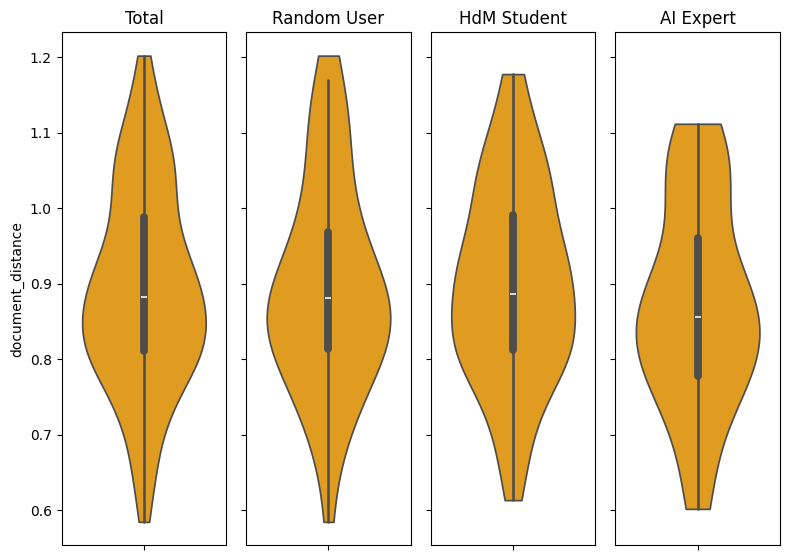

/tmp/ipykernel_304115/1941450650.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors="coerce")


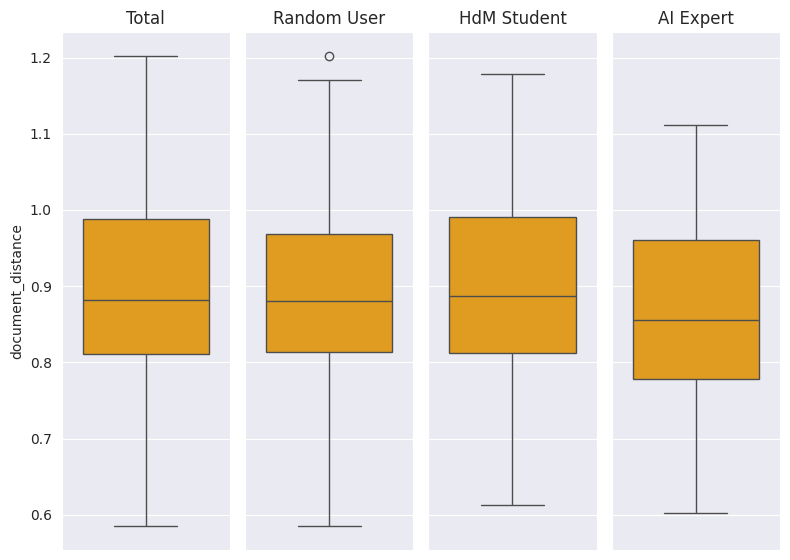

In [34]:
print("max: ", df["document_distance"].max())
print("min: ", df["document_distance"].min())
violinplots("document_distance")
boxplots("document_distance")

max:  25.62
min:  0.72


/tmp/ipykernel_304115/1941450650.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors="coerce")


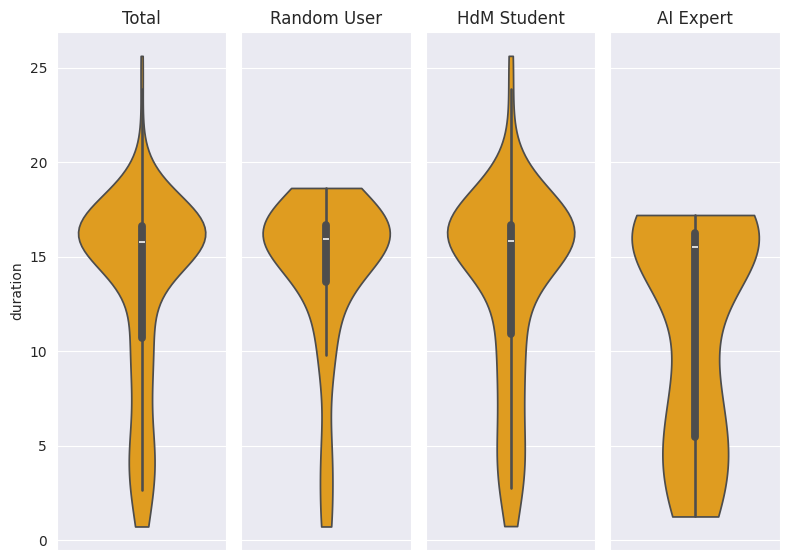

/tmp/ipykernel_304115/1941450650.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors="coerce")


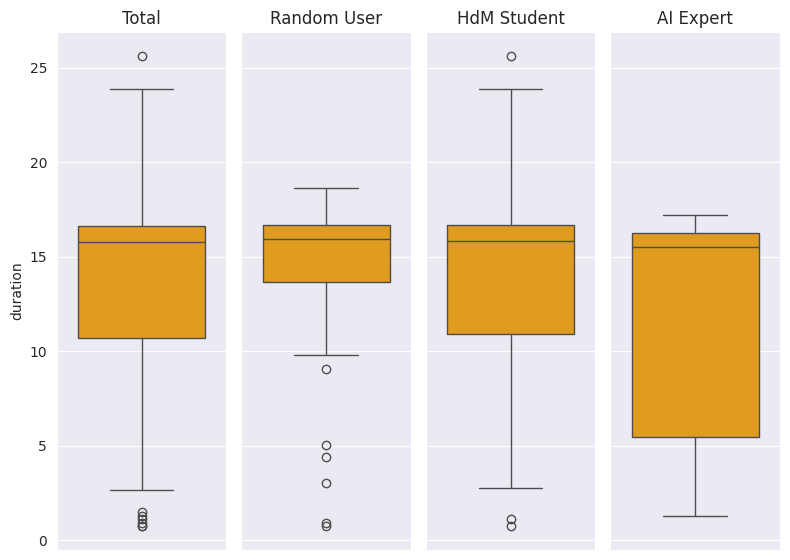

In [35]:
print("max: ", df["duration"].max())
print("min: ", df["duration"].min())
violinplots("duration")
boxplots("duration")

/tmp/ipykernel_304115/1941450650.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors="coerce")


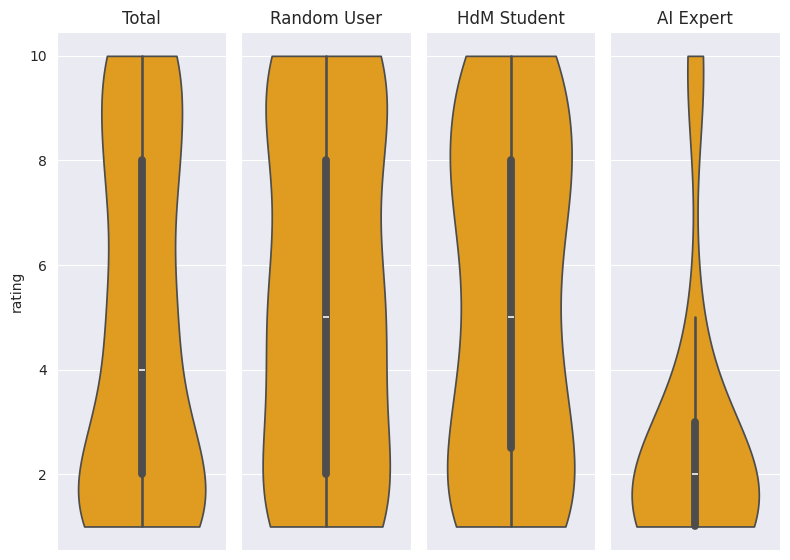

/tmp/ipykernel_304115/1941450650.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors="coerce")


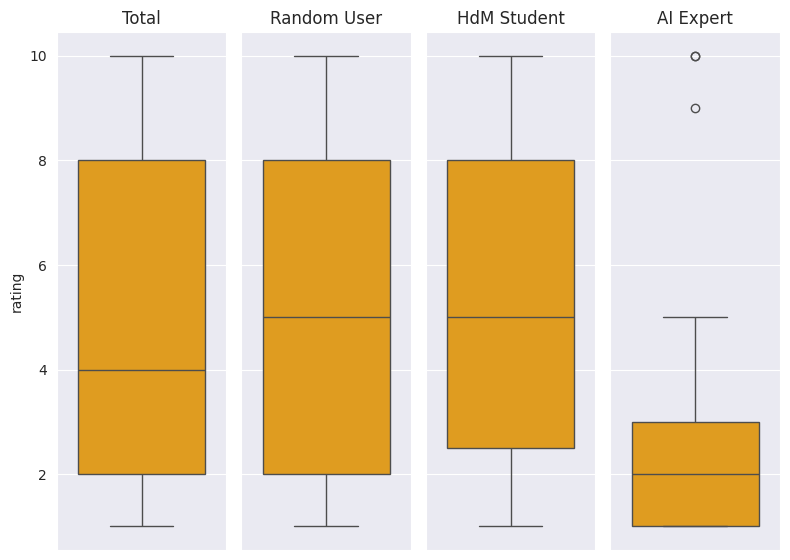

In [36]:
violinplots("rating")
boxplots("rating")